In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
features = pd.read_csv('../data/features.csv')
stores = pd.read_csv('../data/stores.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
features[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = \
    features[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

features[['CPI', 'Unemployment']] = features[['CPI', 'Unemployment']].ffill()

In [4]:
features['Date'] = pd.to_datetime(features['Date'])

features['Year'] = features['Date'].dt.year
features['Month'] = features['Date'].dt.month
features['Week'] = features['Date'].dt.isocalendar().week
features['Day'] = features['Date'].dt.day
features['DayOfWeek'] = features['Date'].dt.dayofweek
features['IsWeekend'] = features['DayOfWeek'].isin([5, 6]).astype(int)

features['IsHoliday'] = features['IsHoliday'].astype(int)

In [5]:
stores = pd.get_dummies(stores, columns=['Type'])

In [6]:
stores[['Type_A', 'Type_B', 'Type_C']] = stores[['Type_A', 'Type_B', 'Type_C']].astype(int)

In [7]:
full_features = features.merge(stores, on='Store', how='left')

In [8]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [9]:
train_df = train.merge(full_features, on=['Store', 'Date'], how='left')
test_df = test.merge(full_features, on=['Store', 'Date'], how='left')

In [10]:
train_df = train_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])

In [11]:
train_df['IsHoliday_x'] = train_df['IsHoliday_x'].astype(int)
test_df['IsHoliday_x'] = test_df['IsHoliday_x'].astype(int)

Text(0.5, 1.0, 'Weekly Sales')

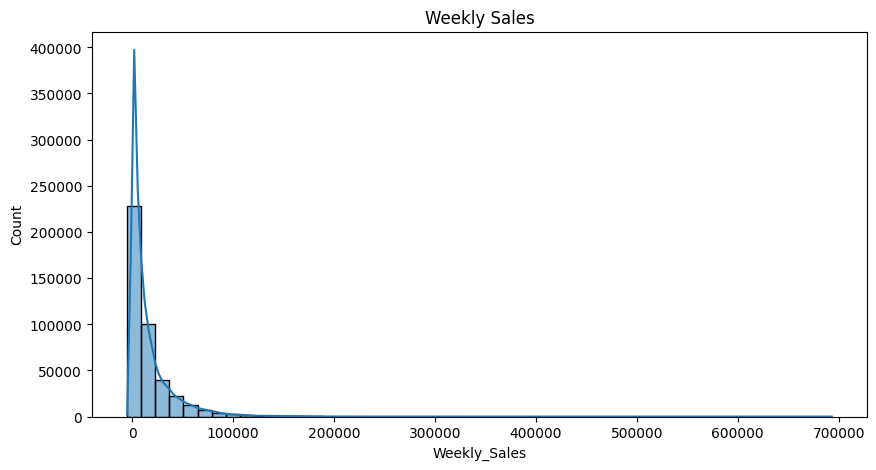

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(train['Weekly_Sales'], bins=50, kde=True)
plt.title('Weekly Sales')

In [13]:
train_df['IsHoliday'] = train_df['IsHoliday_x']
train_df = train_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

In [14]:
test_df['IsHoliday'] = test_df['IsHoliday_x']
test_df = test_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])

In [15]:
numeric_features = train_df.select_dtypes(include=['float64', 'int64'])

In [16]:
corr_matrix = numeric_features.corr()

Text(0.5, 1.0, 'Correlation Matrix')

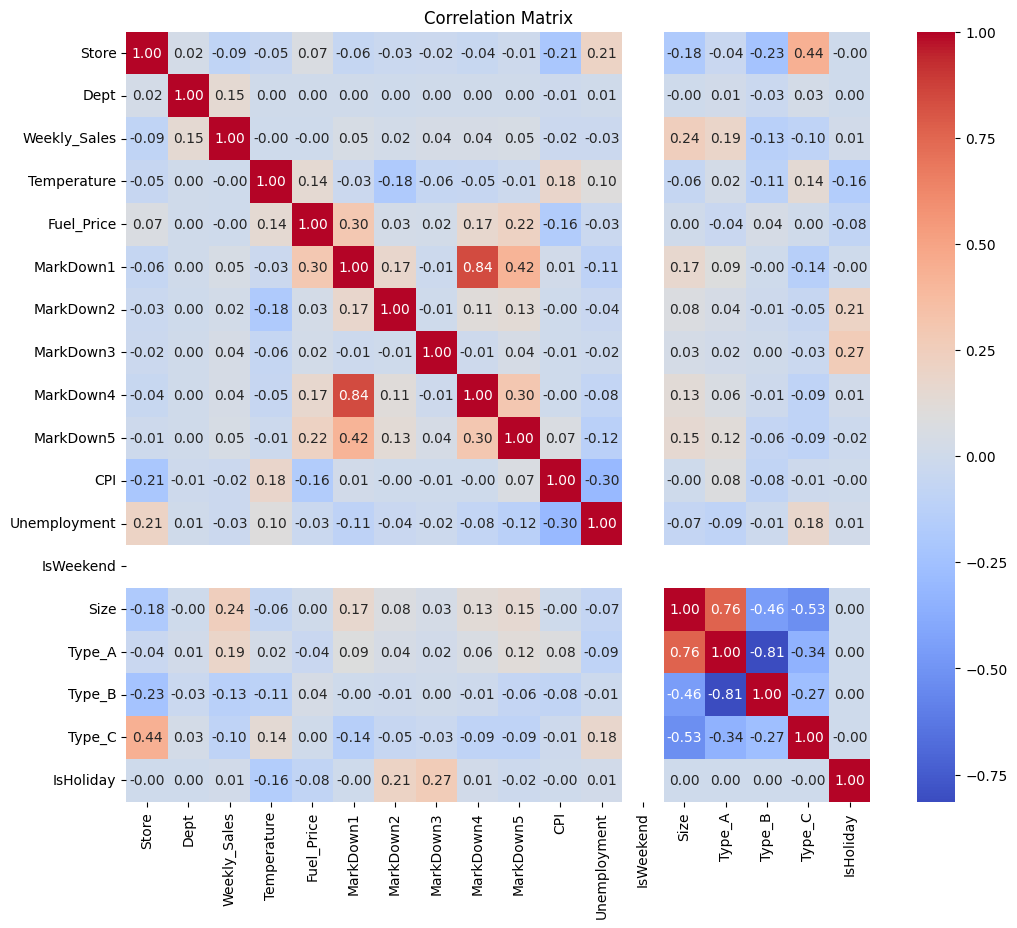

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')

In [18]:
y = train_df['Weekly_Sales']
X = train_df.drop(columns=['Weekly_Sales'])

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

In [20]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [21]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,  
    'num_leaves': 200,      
    'max_depth': 15,         
    'min_child_samples': 50,   
    'feature_fraction': 0.8,   
    'bagging_fraction': 0.8,   
    'bagging_freq': 1,        
    'lambda_l1': 0,         
    'lambda_l2': 0,           
    'verbose': -1
}

In [22]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,    
    valid_sets=[lgb_train, lgb_test],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50)
    ]
)


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 6432.91	valid_1's rmse: 6591.26
[100]	training's rmse: 4670.07	valid_1's rmse: 4846.5
[150]	training's rmse: 4110.82	valid_1's rmse: 4320.68
[200]	training's rmse: 3867.82	valid_1's rmse: 4100.8
[250]	training's rmse: 3675.75	valid_1's rmse: 3941.11
[300]	training's rmse: 3542.53	valid_1's rmse: 3827.62
[350]	training's rmse: 3426.22	valid_1's rmse: 3741.96
[400]	training's rmse: 3337.77	valid_1's rmse: 3677.62
[450]	training's rmse: 3244.35	valid_1's rmse: 3607.86
[500]	training's rmse: 3174.93	valid_1's rmse: 3561.18
[550]	training's rmse: 3118	valid_1's rmse: 3528.03
[600]	training's rmse: 3061.34	valid_1's rmse: 3492.51
[650]	training's rmse: 2994.64	valid_1's rmse: 3446.78
[700]	training's rmse: 2941.19	valid_1's rmse: 3409.27
[750]	training's rmse: 2898.35	valid_1's rmse: 3385.71
[800]	training's rmse: 2851.06	valid_1's rmse: 3358.52
[850]	training's rmse: 2812.31	valid_1's rmse: 3334.54
[900]	trai

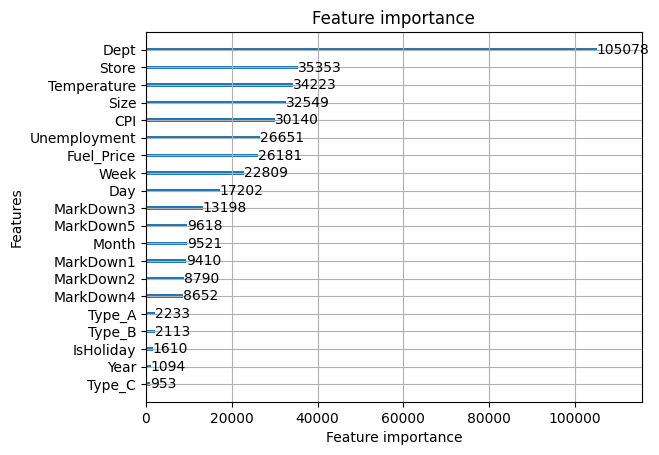

In [131]:
lgb.plot_importance(model, max_num_features=20, importance_type='split')
plt.show()

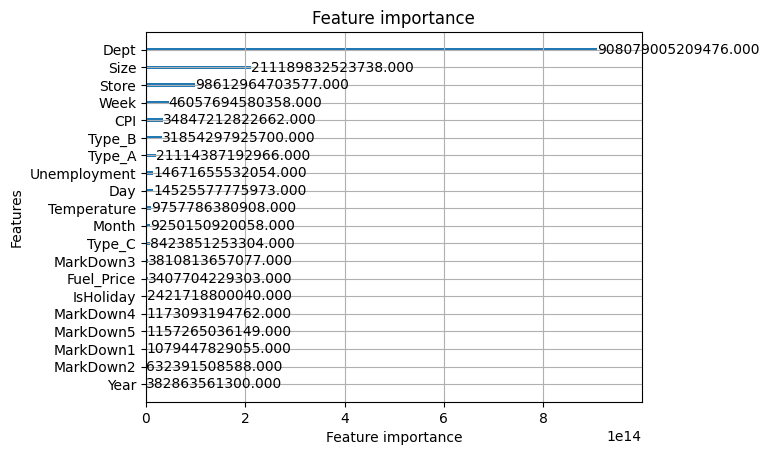

In [132]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.show()

In [23]:
val_pred = model.predict(X_val)

In [25]:
rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
mae_val = mean_absolute_error(y_val, val_pred)
r2_val = r2_score(y_val, val_pred)

In [26]:
print(f'Validation RMSE: {rmse_val:.2f}')
print(f'Validation MAE: {mae_val:.2f}')
print(f'Validation R2: {r2_val:.2f}')

Validation RMSE: 3060.93
Validation MAE: 1491.76
Validation R2: 0.98


In [29]:
full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full = pd.concat([y_train, y_val], ignore_index=True)

In [32]:
lgb_full = lgb.Dataset(full_train, label=y_full)

In [33]:
final_model = lgb.train(
    params,
    lgb_full,
    num_boost_round=model.best_iteration
)

In [34]:
y_full_pred = final_model.predict(full_train)

rmse_full = np.sqrt(mean_squared_error(y_full, y_full_pred))
mae_full = mean_absolute_error(y_full, y_full_pred)
r2_full = r2_score(y_full, y_full_pred)

print(f"Full Train RMSE: {rmse_full:.2f}")
print(f"Full Train MAE: {mae_full:.2f}")
print(f"Full Train R2: {r2_full:.4f}")

Full Train RMSE: 2222.93
Full Train MAE: 1200.29
Full Train R2: 0.9904


In [35]:
final_pred = final_model.predict(test_df)

Text(0, 0.5, 'Count')

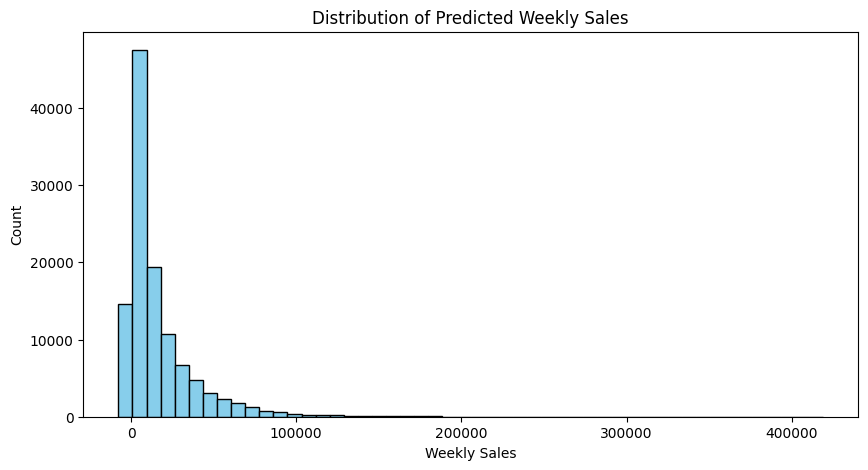

In [36]:
plt.figure(figsize=(10, 5))
plt.hist(final_pred, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Count')

In [39]:
print("Mean:", np.mean(final_pred))
print("Median:", np.median(final_pred))
print("Max:", np.max(final_pred))
print("Min:", np.min(final_pred))
print("Std:", np.std(final_pred))

Mean: 16523.392479898797
Median: 8049.66454465571
Max: 418915.0873583132
Min: -7663.258694061428
Std: 22991.13940940276
